In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

Performance of best pre T-loss model on vermiere

In [2]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\best_pre_tloss", "best_pre_tloss")
solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions.csv"))
solprop_predictions[['solvent smiles', 'solute smiles']] = solprop_predictions['smiles'].str.split('.', n=1, expand=True)
solprop_predictions
solute_smiles = solprop_predictions.pop('solute smiles')  
solvent_smiles = solprop_predictions.pop('solvent smiles')  
both = solprop_predictions.pop('smiles')  

solprop_predictions.insert(0, 'solvent smiles', solvent_smiles) 
solprop_predictions.insert(0, 'solute smiles', solute_smiles) 

In [3]:
grouped_predictions = solprop_predictions.groupby(['solvent smiles', 'solute smiles'])

# Create a list of smaller dataframes
sub_dfs = [group for _, group in grouped_predictions]

In [4]:
total_predicted_gradients = []
total_true_gradients = []
for df in sub_dfs:
    if(len(df) > 1):
        total_true_gradients.append(np.gradient(df['logS_true'], df['temperature']).flatten())
        total_predicted_gradients.append(np.gradient(df['logS_pred'], df['temperature']).flatten())

c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1247: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1256: RuntimeWarning: divide by zero encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f

In [5]:
true_grads = np.concatenate(total_true_gradients).ravel()
pred_grads = np.concatenate(total_predicted_gradients).ravel()
mask = np.isfinite(true_grads) & np.isfinite(pred_grads) 
true_grads = true_grads[mask]
pred_grads = pred_grads[mask]

print(len(true_grads), len(pred_grads))

4183 4183


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

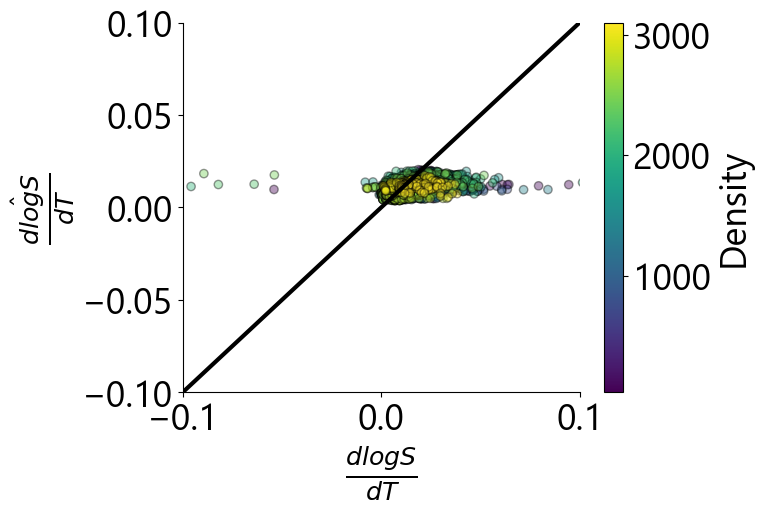

In [6]:
plt.figure(figsize=[6.4,4.8])
fig, ax1 = plt.subplots()

bins = [100, 100] # number of bins
hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
idx = z.argsort()
x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


ax1.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
cbar.ax.set_ylabel('Density')


ax1.set_xlim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])
ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)


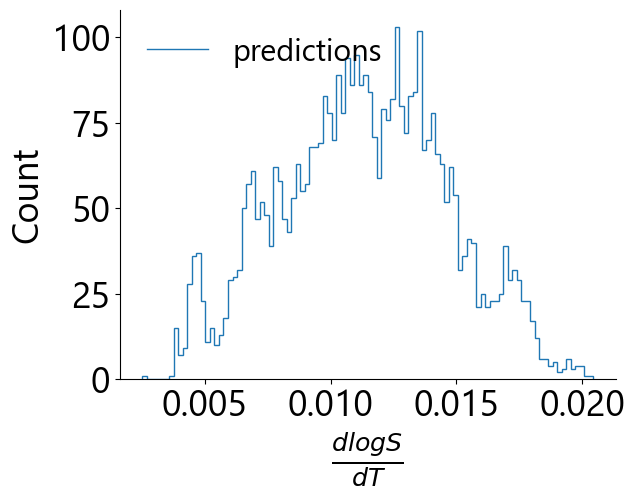

In [7]:
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = 100)
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = 100)

plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()

#ax1.stairs(true_grads_binned, true_grad_bins, label = r'ground truth')
ax1.stairs(pred_grads_binned,pred_grad_bins, label = r'predictions')

#ax1.set_xlim([-0.05, 0.05])
#ax1.set_ylim([-500, 22000])
ax1.set_ylabel(r"Count")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)

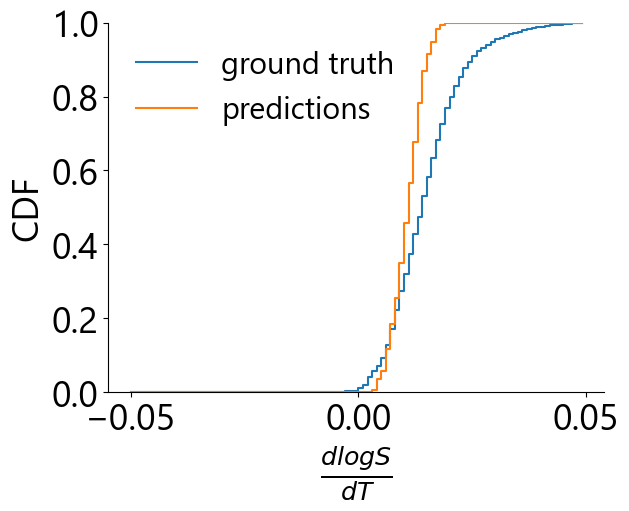

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Compute histograms
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins=100, range = (-0.05, 0.05))
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins=100, range = (-0.05, 0.05)
)

# Compute the CDF
true_grads_cdf = np.cumsum(true_grads_binned) / np.sum(true_grads_binned)
pred_grads_cdf = np.cumsum(pred_grads_binned) / np.sum(pred_grads_binned)

# Create the plot
plt.figure(figsize=[6.4, 4.8])
ax1 = plt.gca()

# Plot the CDFs as step plots
ax1.step(true_grad_bins[:-1], true_grads_cdf, where='post', label='ground truth')
ax1.step(pred_grad_bins[:-1], pred_grads_cdf, where='post', label='predictions')

# Set axis limits
ax1.set_ylim([0, 1])
ax1.set_ylabel("CDF")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)
ax1.spines[['right', 'top']].set_visible(False)

# Show the plot
plt.show()


In [9]:
from scipy.stats import wasserstein_distance
distance = wasserstein_distance(true_grads_cdf, pred_grads_cdf)
print(distance)

0.044372134854558536


Performance of best model on vermiere

In [10]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents", "highsol")
solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions.csv"))
solprop_predictions[['solvent smiles', 'solute smiles']] = solprop_predictions['smiles'].str.split('.', n=1, expand=True)
solprop_predictions
solute_smiles = solprop_predictions.pop('solute smiles')  
solvent_smiles = solprop_predictions.pop('solvent smiles')  
both = solprop_predictions.pop('smiles')  

solprop_predictions.insert(0, 'solvent smiles', solvent_smiles) 
solprop_predictions.insert(0, 'solute smiles', solute_smiles) 

In [11]:
grouped_predictions = solprop_predictions.groupby(['solvent smiles', 'solute smiles'])

# Create a list of smaller dataframes
sub_dfs = [group for _, group in grouped_predictions]

In [12]:
total_predicted_gradients = []
total_true_gradients = []
for df in sub_dfs:
    if(len(df) > 1):
        total_true_gradients.append(np.gradient(df['logS_true'], df['temperature']).flatten())
        total_predicted_gradients.append(np.gradient(df['logS_pred'], df['temperature']).flatten())

c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1247: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1256: RuntimeWarning: divide by zero encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f

In [13]:
true_grads = np.concatenate(total_true_gradients).ravel()
pred_grads = np.concatenate(total_predicted_gradients).ravel()
mask = np.isfinite(true_grads) & np.isfinite(pred_grads) 
true_grads = true_grads[mask]
pred_grads = pred_grads[mask]

print(len(true_grads), len(pred_grads))

4183 4183


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

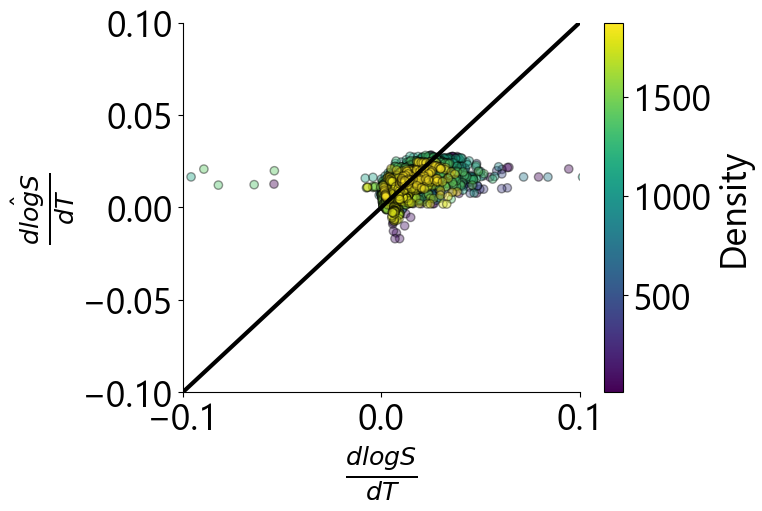

In [14]:
plt.figure(figsize=[6.4,4.8])
fig, ax1 = plt.subplots()

bins = [100, 100] # number of bins
hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
idx = z.argsort()
x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


ax1.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
cbar.ax.set_ylabel('Density')


ax1.set_xlim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])
ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)


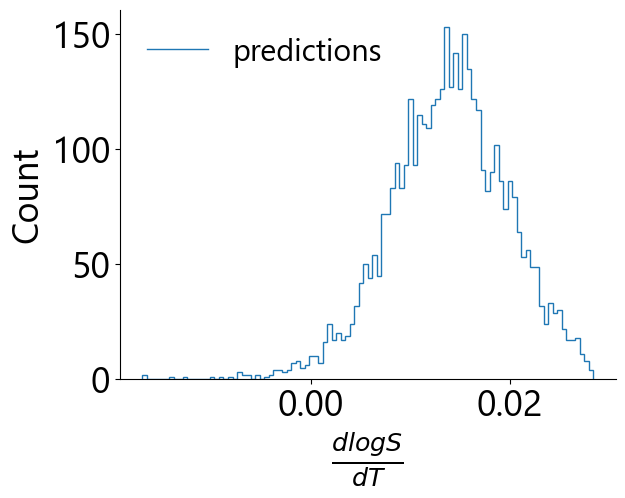

In [15]:
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = 100)
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = 100)

plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()

#ax1.stairs(true_grads_binned, true_grad_bins, label = r'ground truth')
ax1.stairs(pred_grads_binned,pred_grad_bins, label = r'predictions')

#ax1.set_xlim([-0.05, 0.05])
#ax1.set_ylim([-500, 22000])
ax1.set_ylabel(r"Count")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)

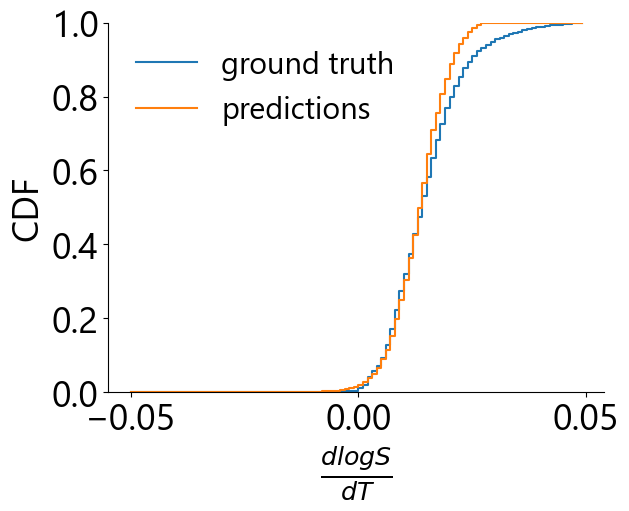

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Compute histograms
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins=100, range = (-0.05, 0.05))
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins=100, range = (-0.05, 0.05)
)

# Compute the CDF
true_grads_cdf = np.cumsum(true_grads_binned) / np.sum(true_grads_binned)
pred_grads_cdf = np.cumsum(pred_grads_binned) / np.sum(pred_grads_binned)

# Create the plot
plt.figure(figsize=[6.4, 4.8])
ax1 = plt.gca()

# Plot the CDFs as step plots
ax1.step(true_grad_bins[:-1], true_grads_cdf, where='post', label='ground truth')
ax1.step(pred_grad_bins[:-1], pred_grads_cdf, where='post', label='predictions')

# Set axis limits
ax1.set_ylim([0, 1])
ax1.set_ylabel("CDF")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)
ax1.spines[['right', 'top']].set_visible(False)

# Show the plot
plt.show()


In [17]:
from scipy.stats import wasserstein_distance
distance = wasserstein_distance(true_grads_cdf, pred_grads_cdf)
print(distance)

0.01698698955168204


Performance of Vermiere on Solprop

In [18]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents", "highsol")
vermiere_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_vermeire_predictions.csv"))
vermiere_solprop_predictions = vermiere_solprop_predictions.rename(columns = {"Solvent": "solvent smiles","Solute": "solute smiles", "Temp" : "temperature"})

In [19]:
solprop_predictions_new = solprop_predictions.merge(vermiere_solprop_predictions[['solute smiles', 'solvent smiles', 'temperature', 'logST (method1) [log10(mol/L)]']], 
                on=['solute smiles', 'solvent smiles', 'temperature'], 
                how='left')

In [25]:
solprop_predictions_new

,solute smiles,solvent smiles,logS_true,temperature,logS_pred,stdev,logST (method1) [log10(mol/L)]
0,C1=CC=C2C=C3C=CC=CC3=CC2=C1,CCO,-2.064830,298.20,-2.209070,0.029533,-1.504386
1,C1=CC=C2C=C3C=CC=CC3=CC2=C1,CCO,-1.949980,308.20,-2.008475,0.037393,-1.375185
2,C1=CC=C2C=C3C=CC=CC3=CC2=C1,CCO,-1.887900,318.20,-1.812146,0.049731,-1.254105
3,C1=CC=C2C=C3C=CC=CC3=CC2=C1,CCO,-0.610190,393.00,-0.863337,0.038215,-0.543850
4,C1=CC=C2C=C3C=CC=CC3=CC2=C1,CCO,-0.391940,413.00,-0.749946,0.087402,-0.397534
...,...,...,...,...,...,...,...
5364,CC1=CC=C(C=C1)C(=O)O,CN(C)C=O,0.731971,328.95,0.693223,0.146920,0.314549
5365,CC1=CC=C(C=C1)C(=O)O,CN(C)C=O,0.777212,331.65,0.707246,0.138972,0.323432
5366,CC1=CC=C(C=C1)C(=O)O,CN(C)C=O,0.801685,333.05,0.714706,0.135200,0.327981
5367,CC1=CC=C(C=C1)C(=O)O,CN(C)C=O,0.838156,335.05,0.725191,0.129639,0.334414


In [26]:
grouped_predictions = solprop_predictions_new.groupby(['solvent smiles', 'solute smiles'])

# Create a list of smaller dataframes
sub_dfs = [group for _, group in grouped_predictions]

In [27]:
total_predicted_gradients = []
total_true_gradients = []
for df in sub_dfs:
    if(len(df) > 1):
        total_true_gradients.append(np.gradient(df['logS_true'], df['temperature']).flatten())
        total_predicted_gradients.append(np.gradient(df['logST (method1) [log10(mol/L)]'], df['temperature']).flatten())



c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\ProgramData\Miniconda3\envs\PythonDeepChemENV\lib\site-packages\numpy\li

In [36]:
true_grads = np.concatenate(total_true_gradients).ravel()
pred_grads = np.concatenate(total_predicted_gradients).ravel()
mask = np.isfinite(true_grads) & np.isfinite(pred_grads) 
true_grads = true_grads[mask]
pred_grads = pred_grads[mask]

print(len(true_grads), len(pred_grads))

3992 3992


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

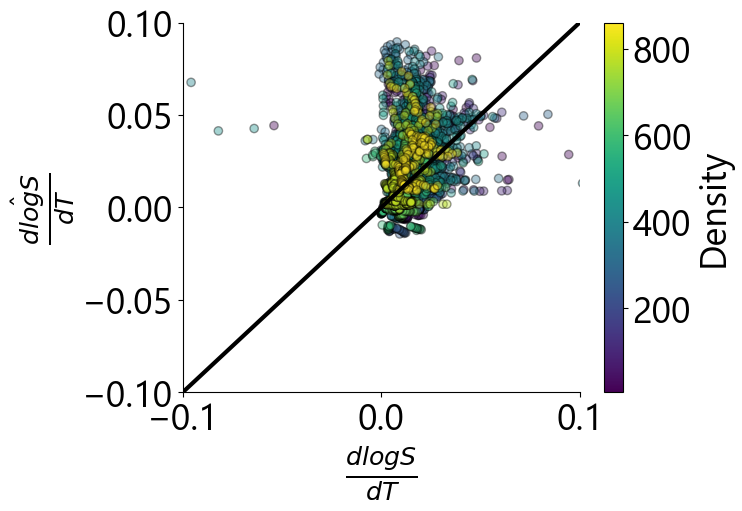

In [38]:
plt.figure(figsize=[6.4,4.8])
fig, ax1 = plt.subplots()

bins = [100, 100] # number of bins
hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
idx = z.argsort()
x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


ax1.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
cbar.ax.set_ylabel('Density')


ax1.set_xlim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])
ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)


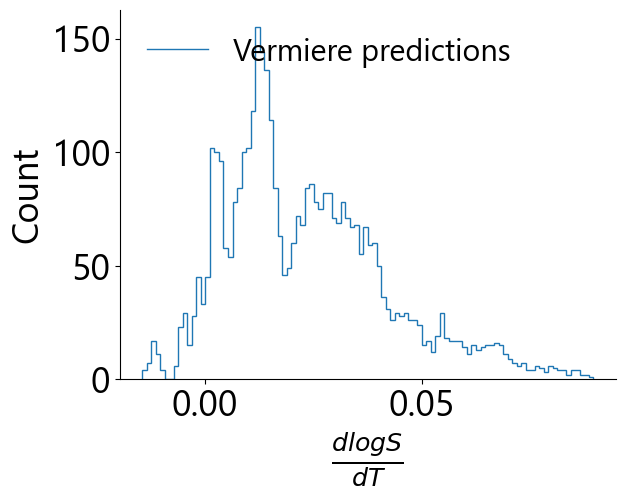

In [41]:
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = 100)
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = 100)

plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()

#ax1.stairs(true_grads_binned, true_grad_bins, label = r'ground truth')
ax1.stairs(pred_grads_binned,pred_grad_bins, label = r'Vermiere predictions')

#ax1.set_xlim([-0.05, 0.05])
#ax1.set_ylim([-500, 22000])
ax1.set_ylabel(r"Count")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
ax1.spines[['right', 'top']].set_visible(False)

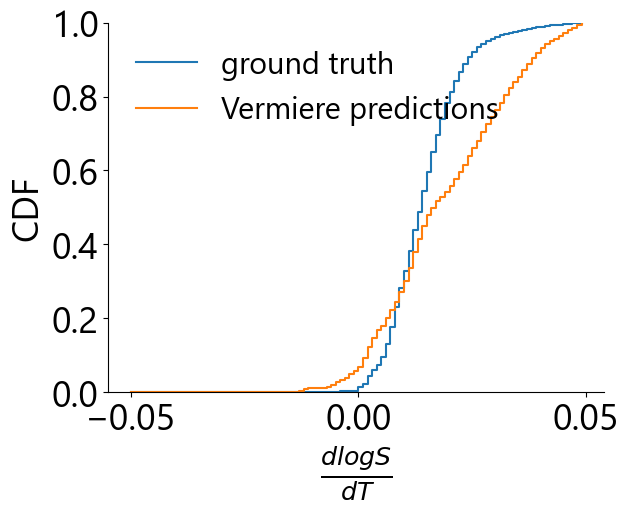

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Compute histograms
true_grads_binned, true_grad_bins = np.histogram(true_grads, bins=100, range = (-0.05, 0.05))
pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins=100, range = (-0.05, 0.05)
)

# Compute the CDF
true_grads_cdf = np.cumsum(true_grads_binned) / np.sum(true_grads_binned)
pred_grads_cdf = np.cumsum(pred_grads_binned) / np.sum(pred_grads_binned)

# Create the plot
plt.figure(figsize=[6.4, 4.8])
ax1 = plt.gca()

# Plot the CDFs as step plots
ax1.step(true_grad_bins[:-1], true_grads_cdf, where='post', label='ground truth')
ax1.step(pred_grad_bins[:-1], pred_grads_cdf, where='post', label='Vermiere predictions')

# Set axis limits
ax1.set_ylim([0, 1])
ax1.set_ylabel("CDF")
ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)
ax1.spines[['right', 'top']].set_visible(False)

# Show the plot
plt.show()


In [40]:
from scipy.stats import wasserstein_distance
distance = wasserstein_distance(true_grads_cdf, pred_grads_cdf)
print(distance)

0.06212163721800503
